In [145]:
import pandas as pd
import numpy as np
import os
import leg_controllers.hopper as hopper
import leg_controllers.model as model
from leg_controllers.designs import Params
import yaml
from scipy.linalg import expm

data_dir = "data/design1" 
files = os.listdir(data_dir)
experiments = []
for fname in files:
    trials = pd.read_excel(data_dir+'/'+fname,sheet_name=None)
    experiments += [trials]
params = None
with open("../designs/design1.yaml","r") as f:
    params = Params(*(yaml.load(f,yaml.Loader).values()))

f=7.5.xlsx


C:\Users\spear\AppData\Local\Temp/ipykernel_27208/2601894751.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y0.append(np.linalg.lstsq(Phi,b)[0])
C:\Users\spear\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\spear\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'whiskers': [<matplotlib.lines.Line2D at 0x217918a2190>,
 'caps': [<matplotlib.lines.Line2D at 0x217918a2730>,
 'boxes': [<matplotlib.lines.Line2D at 0x21791a0bfa0>],
 'medians': [<matplotlib.lines.Line2D at 0x217918a2e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x217918b1130>],
 'means': []}

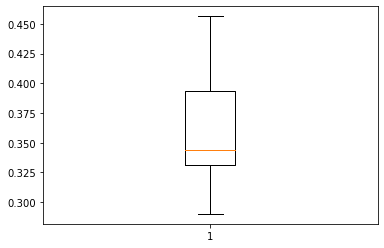

In [172]:
# ok that worked pretty well, now we need to do it for all of the stance periods
idx = 7
print(files[idx])
data = experiments[idx]
stance_sheets = [ name for name in data.keys() if "stance" in name ]
# throw out first 5
stance_sheets = stance_sheets[5:-1]
y0 = []
for sheet in stance_sheets:
    t = np.array(data[sheet].iloc[:,0])
    dt = np.average(np.diff(t))
    y = np.array(data[sheet]["q0"])-params.l1-params.l2-model.foot_offset

    A = np.array([
        [0.,1.,0.],
        [-hopper.omega**2,0.,-model.g],
        [0.,0.,0.]
    ])

    e1 = np.eye(3)
    eAt = np.vstack([expm(A*(t[i]-t[0])) for i in range(len(t))])
    Phi = eAt[0:-1:3,0:2]
    b = y - eAt[0:-1:3,2]
    y0.append(np.linalg.lstsq(Phi,b)[0])
from matplotlib import pyplot as plt
y0 = np.vstack(y0)
E = .5*y0[:,1]**2+.5*hopper.omega**2 * y0[:,0]**2 + model.g*y0[:,0]
E_avg = np.average(E)
E_std = np.std(E)

# filter outliers

E = E[np.abs(E-E_avg)<2*E_std]